# SIGNAL PROCESSING PROJECT - M2 AI
## Audio Declipping with Social Sparsity

- Benedictus Kent Rachmat
- Jacobo Ruiz Ocampo

[paper link](https://hal.science/hal-01002998/document)

---

## IMPORT

In [43]:
import numpy as np 
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.optimize import fsolve

In [44]:
def compute_snr(signal, noise, masks=1): 
    """
    Computes the Signal-to-Noise Ratio (SNR) for a given signal and noise.
    ----------
    :param signal: The original signal.
    :param noise: The noise in the signal.
    :param masks: Masks to apply to the signal and noise.
    :returns: The calculated SNR.
    """
    return 20 * np.log10(np.linalg.norm(masks * signal) / np.linalg.norm(masks * noise))

def threshold_clip(audio_signal, amplitude_threshold): 
    """
    Clips an audio signal to a specified amplitude threshold.
    ----------
    :param audio_signal: The audio signal to be clipped.
    :param amplitude_threshold: The threshold for clipping the amplitude.
    :returns: (the clipped audio, the mask indicating where the signal was clipped)
    """
    lower_limit, upper_limit = -amplitude_threshold, amplitude_threshold
    mask_info = (audio_signal > upper_limit) | (audio_signal < lower_limit)

    clipped_signal = np.clip(audio_signal, lower_limit, upper_limit)

    return clipped_signal, mask_info

def snr_based_clip(audio_signal, target_snr): 
    """
    Clips an audio signal based on a target Signal-to-Noise Ratio (SNR).
    ----------
    :param audio_signal: The audio signal to be clipped.
    :param target_snr: The target SNR in decibels.
    :returns: 
            - Clipped signal
            - The mask indicating where the signal was clipped
            - The amplitude threshold
    """
    amplitude_threshold = fsolve(lambda T: compute_snr(audio_signal, audio_signal - threshold_clip(audio_signal, T)[0]) - target_snr, 0)[0]
    clipped_signal, masks = threshold_clip(audio_signal, amplitude_threshold)
    return clipped_signal, masks, amplitude_threshold

We load `music.wav` and implement audio clipping controlled by the Signal-to-Noise Ratio (SNR). The `snr_based_clip` function adjusts the clipping level of an audio signal to achieve a specified SNR target. First, it determines the appropriate amplitude threshold needed to reach the desired SNR. This is achieved using the fsolve function, which finds the root of the equation where the computed SNR of the clipped signal equals the target SNR. The SNR is calculated using the formula: 
$$ \text{SNR} = 20 \times \log_{10}\left(\frac{\|\text{signal} \|}{\| \text{noise} \|}\right) $$
where `signal` is the original audio signal, and `noise` is the difference between the original and clipped signals. After finding the amplitude threshold, the function applies threshold clipping to the audio signal.

140001

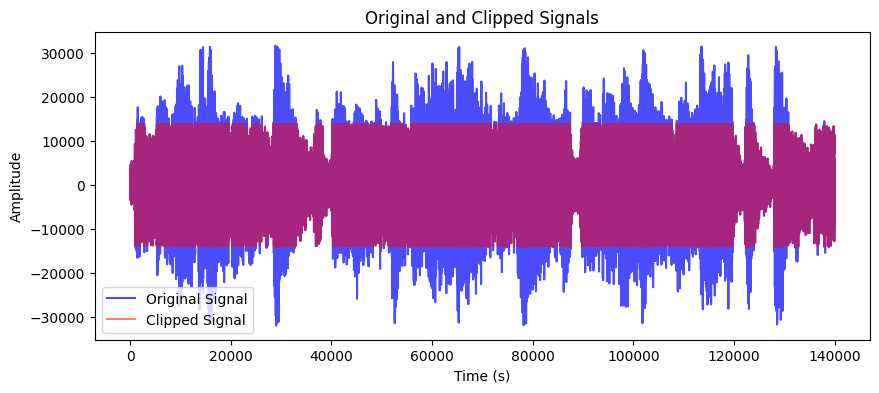

In [60]:
sampling_rate, audio_data = wavfile.read("music.wav")
length_data = len(audio_data)
target_snr = 15

clipped_data, clipping_masks, clip_threshold = snr_based_clip(audio_data, target_snr)

plt.figure(figsize=(10, 4))
plt.title("Original and Clipped Signals")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(audio_data, label="Original Signal", color="blue", alpha=0.7)
plt.plot(clipped_data, label="Clipped Signal", color="red", alpha=0.5)
plt.legend()
plt.show()

Audio(clipped_data, rate=sampling_rate)

The paper mentioned 4 shrinkage methods as follows: 

#### Lasso Method
This approach alters the time-frequency coefficients $\alpha_{tf}$ using a Lasso-inspired formula. The formula is:
$$\tilde{\alpha}{tf} = \alpha{tf} (1 - \frac{\lambda}{|\alpha_{tf}|})^{+}$$

Here, the Lasso shrinkage is applied to each coefficient independently.

#### Windowed Group-Lasso (WGL)
This method extends the Lasso approach by considering the local neighborhood of each time-frequency coefficient. The formula is:
$$\tilde{\alpha}{tf} = \alpha{tf} (1 - \frac{\lambda}{\sqrt{\sum_{t' \in \mathcal{N}(t)} |\alpha_{t'f}|^2}})^{+}$$
It takes into account the energy of coefficients in a specified neighborhood, promoting group sparsity.

#### Empirical Wiener (EW)
In this approach, the coefficients are adjusted using an empirical Wiener-like method. The formula is:
$$\tilde{\alpha}{tf} = \alpha{tf} (1 - \frac{\lambda^2}{|\alpha_{tf}|^2})^{+}$$
This method applies a squared ratio for the shrinkage, differing from the Lasso method.

#### Persistent Empirical Wiener (PEW)
Similar to EW, this method also uses a Wiener-like approach but includes neighborhood considerations. The formula is:
$$\tilde{\alpha}{tf} = \alpha{tf} (1 - \frac{\lambda^2}{\sum_{t' \in \mathcal{N}(t)} |\alpha_{t'f}|^2})^{+}$$
It computes the ratio based on the sum of squared coefficients in a local neighborhood, encouraging a persistent sparsity pattern.

Where:
- $\tilde{\alpha}{tf}$: the adjusted coefficient
- $\alpha{tf}$: the original coefficient
- $\lambda$: a threshold parameter
- $\mathcal{N}(t)$: the neighborhood of time index $t$
- The subscript $+$: the operation inside the parenthesis is clipped at zero

In [46]:
def compute_neighborhood(alpha, size):
    """
    Computes the neighborhood of squared alpha values using convolution.
    ----------
    :param alpha: The input alpha values.
    :param size: The size of the neighborhood kernel.
    :returns: The convolved result representing the neighborhood.
    """
    kernel = np.full((size, 1), fill_value=1/size)
    
    # Compute squared alpha values
    squared_alpha = np.square(np.abs(alpha))
    
    # Convolve squared alpha with the kernel
    convolved_result = signal.convolve2d(squared_alpha, kernel, boundary='symm', mode="same")
    return convolved_result


def lasso(alpha, lamda, size=None):
    """
    Applies Lasso shrinkage operator to alpha.
    ----------
    :param alpha: The input alpha values.
    :param lamda: The threshold parameter for Lasso shrinkage.
    :param size: Size parameter (not used).
    :returns: The result of Lasso shrinkage on alpha.
    """
    return alpha * (1 - lamda / np.abs(alpha)).clip(min=0)


def wgl(alpha, lamda, size=None):
    """
    Applies Weighted Group Lasso (WGL) shrinkage operator to alpha.
    ----------
    :param alpha: The input alpha values.
    :param lamda: The threshold parameter for WGL shrinkage.
    :param size: The size parameter for computing the neighborhood.
    :returns: The result of WGL shrinkage on alpha.
    """
    return alpha * (1 - lamda / np.sqrt(compute_neighborhood(alpha, size))).clip(min=0)


def ew(alpha, lamda, size=None):
    """
    Applies Exponential Weighted (EW) shrinkage operator to alpha.
    ----------
    :param alpha: The input alpha values.
    :param lamda: The threshold parameter for EW shrinkage.
    :param size: Size parameter (not used).
    :returns: The result of EW shrinkage on alpha.
    """
    return alpha * (1 - (lamda / np.abs(alpha)) ** 2).clip(min=0)


def pew(alpha, lamda, size=None):
    """
    Applies Partial Exponential Weighted (PEW) shrinkage operator to alpha.
    ----------
    :param alpha: The input alpha values.
    :param lamda: The threshold parameter for PEW shrinkage.
    :param size: The size parameter for computing the neighborhood.
    :returns: The result of PEW shrinkage on alpha.
    """
    return alpha * (1 - lamda**2 / compute_neighborhood(alpha, size)).clip(min=0)

Next, like in the paper, we utilize the Gabor transform for time-frequency analysis. We employ a Hann window of `1024` samples for the Gabor frame, which is particularly suited for a 16 kHz audio sampling frequency. The time-shift parameter is set to `256` samples and window length of `1024`

In [61]:
class GaborTransform:
    def __init__(self, rate, length_data):
        self.rate = rate
        self.window_type = 'hann'
        self.window_length = 1024   
        self.time_shift = 256      
        self.nfft = 2 * self.window_length   
        self.length = length_data

    def stft(self, audio_signal):
        """Performs Short-Time Fourier Transform using a Hann window."""
        _, _, Zxx = signal.stft(
            audio_signal, 
            fs=self.rate, 
            window=self.window_type, 
            nperseg=self.window_length, 
            noverlap=self.window_length - self.time_shift, 
            nfft=self.nfft
        )
        return Zxx

    def istft(self, Zxx):
        """Performs Inverse Short-Time Fourier Transform."""
        _, audio_signal = signal.istft(
            Zxx, 
            fs=self.rate, 
            window=self.window_type, 
            nperseg=self.window_length, 
            noverlap=self.window_length - self.time_shift, 
            nfft=self.nfft
        )
        return audio_signal[:self.length]

In [62]:
Gabor = GaborTransform(sampling_rate, length_data)

In [65]:
def declipping(audio_clipped, clipping_masks, clip_threshold, shrinkage=lasso, max_iter=500, tolerance=1e-5, n_size=5, verbose=False):
    """
    Declipping with ISTA algorithm using Gabor Transform. 
    """
    Zxx_clipped = Gabor.stft(audio_clipped)

    # Initialize ISTA algorithm variables
    audio_declipped = audio_clipped
    alpha = np.zeros_like(Zxx_clipped)   
    z = np.zeros_like(Zxx_clipped)     
    lambda_param = 1   
    k = 1            

    M_c = clipping_masks
    M_r = ~clipping_masks
    theta_clip = audio_clipped * M_c
    y_r = audio_clipped * M_r

    for lambda_param in enumerate(np.logspace(-1, -4, 5)):
        while k <= max_iter:
            temp_data = audio_declipped
            g1 = -Gabor.stft(M_r.T * (y_r - M_r * Gabor.istft(z)))
            g2 = -Gabor.stft(M_c.T * (theta_clip - M_c * Gabor.istft(z)))
            
            alpha = shrinkage(z - (g1 + g2), lambda_param, n_size)
            
            # Relaxation step
            gamma = (k - 1) / (k + 2)  
            z = alpha + gamma * (alpha - z)

            audio_declipped = Gabor.istft(alpha)
            alpha_norm = np.linalg.norm(temp_data - audio_declipped)
            if alpha_norm < tolerance:
                if verbose:
                    print("Convergence reached.")
                break
            
            k += 1 

    return audio_declipped

## Experiments

In [66]:
audio_declipped = declipping(clipped_data, clipping_masks, clip_threshold)

ValueError: operands could not be broadcast together with shapes (2,) (1025,548) 